In [1]:
import numpy as np
import pygalmesh
import meshio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# pygalmesh needs CGAL and Eigen installed on your system
# https://anaconda.org/conda-forge/pygalmesh

### readobj()

In [2]:
'''surftovol()과 비교 및 정보 파악을 위해 따로 작성
You can use any format supported by meshio. (https://github.com/nschloe/meshio)
'''
def readobj(obj_file):
    mesh = meshio.read(obj_file)
    print(mesh)

In [3]:
readobj("bunny.obj")

<meshio mesh object>
  Number of points: 2503
  Number of cells:
    triangle: 4968
  Cell data: obj:group_ids


### draw()

In [4]:
'''for visualize
drawtetras(): 사면체로 나뉜 정보 그리기, 정점 정보 담긴 배열 이용
drawtetras_idx(): 마찬가지로 idx로 그리는 버전 (아마 idx로 그리는 버전만 쓰일 것)
drawtetras_aftermerge(): merge이후 remove list 이용해서 그리기 (use index)
drawCOM(): 질량 중심 좌표들 찍기
'''
def drawtetras_idx(vtxs, tetra_idx, xmin, xmax, ymin, ymax, zmin, zmax):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for tetra in tetra_idx:
        for face in tetra:
            t = [vtxs[idx] for idx in face]
            ax.add_collection3d(Poly3DCollection([t], edgecolor='k', linewidths=0.1, alpha=0.1))
            
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    
def drawtetras(tetrahedra, xmin, xmax, ymin, ymax, zmin, zmax):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for tetra in tetrahedra:
        for t in tetra:
            ax.add_collection3d(Poly3DCollection([t], edgecolor='k', linewidths=0.1, alpha=0.1))
            
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

def drawtetras_aftermerge(vtxs, rm_list, tetra_idx, xmin, xmax, ymin, ymax, zmin, zmax):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for tetra, check_rm in zip(tetra_idx, rm_list):
        for face, check in zip(tetra, check_rm):
            if not check:
                t = [vtxs[idx] for idx in face]
                ax.add_collection3d(Poly3DCollection([t], edgecolor='k', linewidths=0.1, alpha=0.1))

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    
def drawCOM(COM):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for point in COM:
        x = point[0]
        y = point[1]
        z = point[2]
        ax.scatter(x, y, z, color='k', marker='o', s=0.2)

    plt.show()

### Useage

1. surftovol()로 볼륨 형태 만들기
2. COM 구하기 <br>

--- 처리 ---

3. group_id 정보 받아와서
4. merge 진행한담에 vertex 및 face 정보 저장

### MeshProcessor

In [5]:
class Mesh:
    def __init__(self):
        self.vtxs = []
        self.cells = []
        self.tetra_idx = []

    def surftovol(self, obj_file_name):
        '''surface to volume -> get COM
        generate_volume_mesh_from_surface_mesh에서 
            max_radius_surface_delaunay_ball: 표면에서 Delaunay ball의 최대 반지름을 지정
            max_facet_distance: 생성된 면의 최대 거리 제어
        조정해서 쪼개는 정도 설정하기
        '''
        mesh = pygalmesh.generate_volume_mesh_from_surface_mesh(
            obj_file_name,
            min_facet_angle=30.0,
            max_radius_surface_delaunay_ball=0.05,
            max_facet_distance=0.3,
            max_circumradius_edge_ratio=3.0,
            verbose=False,
            reorient=True
        )

        self.vtxs = mesh.points
        self.cells = mesh.get_cells_type("tetra")
    
    def getCOM(self):
        '''get center of mass for every tetrahedra
        '''
        COM = np.zeros((len(self.cells), 3))
        for i, cell in enumerate(self.cells):
            vertices = self.vtxs[cell]
            com = np.mean(vertices, axis=0)
            COM[i] = com

        return COM
    
    def maketetra_idx(self):
        '''make tetra
        cell로 구해진 사면체의 정점 정보를 이용해 combination으로 face 정보 구성
        index version) face 정보를 작성할 때 정점말고 index로 작성한 버전
                       (이후 merge에서 face 비교를 간단히 하기 위해)
        '''
        tetra_idx = []
        combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

        for cell in self.cells:
            tetra = []
            for comb in combinations:
                face_idx = [cell[idx] for idx in comb]
                tetra.append(face_idx)
            tetra_idx.append(tetra)

        return tetra_idx

    def maketetra(self):
        '''
        cell로 구해진 사면체의 정점 정보를 이용해 combination으로 face 정보 구성
        필요한 경우에만 쓰도록 분리, index version에서 같이 구해도 됨
        '''
        tetrahedra = []
        combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

        for cell in self.cells:
            tmp_poly = [self.vtxs[cell[0]], self.vtxs[cell[1]], self.vtxs[cell[2]], self.vtxs[cell[3]]]
            faces = []
            for comb in combinations:
                face = [tmp_poly[idx] for idx in comb]
                faces.append(face)
            tetrahedra.append(faces)

        return tetrahedra
    
    def mergemesh(self, group_id=[]):
        '''
        같은 group(class)인지 체크해서 remove list 작성
        cells(face) 정보에서 값을 지워줘야 할 것 (result에 저장)
        '''
        self.tetra_idx = self.maketetra_idx()
        drawtetras_idx(self.vtxs, self.tetra_idx, -0.8, 0.3, 0.0, 1.1, -0.8, 0.3)     ##

        if not group_id:         # group(class) 정보는 받아올 예정 (없으면 임시로 같은걸로 설정)
            group_id = [0] * len(self.tetra_idx)
        
        # 그래프 부분---------------------------------
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        num_group = len(set(group_id))
        group_id = np.array(group_id)
        
        for num in range(num_group):
            piece = np.where(group_id == num)[0]
            tmp_list = [self.tetra_idx[i] for i in piece]
            rows = len(piece)
            cols = len(tmp_list[0])
            rm_list = [[False for _ in range(cols)] for _ in range(rows)]

            # merge...
            for i in range(len(piece)):
                tetra_A = self.tetra_idx[piece[i]]
                for j in range(i+1, len(piece)):
                    tetra_B = tmp_list[j]
                    for n in range(len(tetra_A)):
                        for m in range(len(tetra_B)):
                            face_A = tetra_A[n]
                            face_B = tetra_B[m]
                            shared_vertices = set(face_A) & set(face_B)
                            if len(shared_vertices) >= 3:
                                rm_list[i][n] = True
                                rm_list[j][m] = True
            result = []
            for tetra, check_rm in zip(tmp_list, rm_list):
                for face, check in zip(tetra, check_rm):
                    if not check:
                        result.append(face)
                        t = [self.vtxs[idx] for idx in face]
                        ax.add_collection3d(Poly3DCollection([t], edgecolor='k', linewidths=0.1, alpha=0.1))     ##
                        
            faces = result
            self.exportmesh(num, result)
        
        # 그래프 부분------------
        ax.set_xlim(-0.8, 0.3)
        ax.set_ylim(0.0, 1.1)
        ax.set_zlim(-0.8, 0.3)

    def exportmesh(self, idx, faces):
        '''
        조각들을 obj로 나눠서 export (only surface)
        '''
        output = meshio.Mesh(points=self.vtxs, cells=[("triangle", faces)])
        meshio.write(f"result{idx}.obj", output, file_format="obj")      #성공
    

In [6]:
mesh = Mesh()
mesh.surftovol("compressed_mesh.obj")
mesh.getCOM()

array([[ 0.38569346,  0.13237178,  0.10250281],
       [-0.17093012, -0.06551725, -0.19197865],
       [-0.0611025 ,  0.33773446, -0.2964623 ],
       ...,
       [ 0.20943581,  0.16285375, -0.20006494],
       [ 0.21901932, -0.11979456, -0.25637609],
       [-0.00223898,  0.16281161, -0.20602345]])

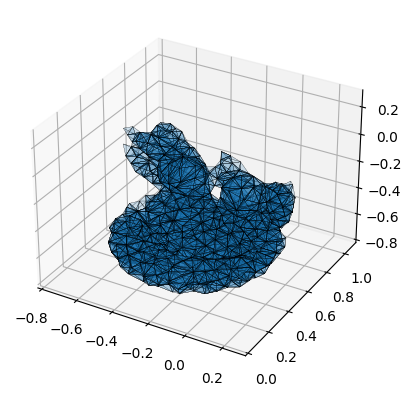

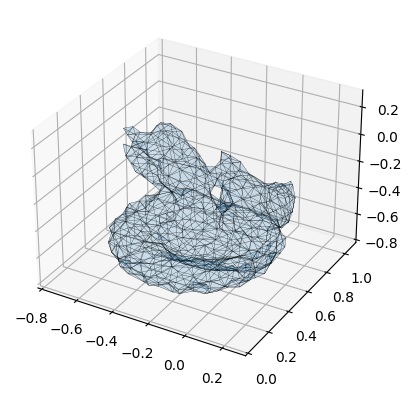

In [7]:
mesh.mergemesh(None)

### Test export

- 조각별로 export 테스트
- 아래 코드 실행시 result0.obj, result1.obj 생성 <br>
  (단 group_id의 경우 0부터 순서대로 설정되어 있어야 함)
- 이 방식으로 위 Mesh class에도 적용했지만 2개 이상의 그룹은 테스트 못해봄 (1개는 문제없음)
- 한가지 문제(...까지는 아니고 특징)는 vertex가 다 저장됨 -> vertex 골라서 넣으려면 face index도 수정해야함 <br>

(-1.0, 1.0)

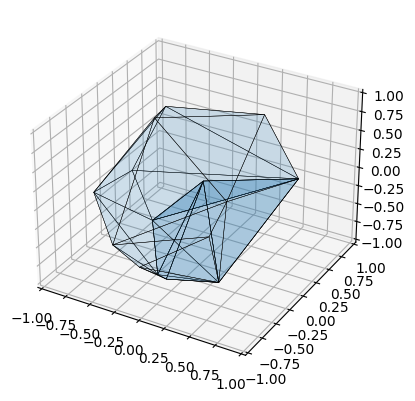

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

s = pygalmesh.Ball([0, 0, 0], 1.0)
myball = pygalmesh.generate_mesh(s, max_cell_circumradius=1.0)

vtxs = myball.points
cells = myball.get_cells_type("tetra")

combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

tetrahedra = []
tetra_idx = []

for cell in cells:
    tmp_poly = [vtxs[cell[0]], vtxs[cell[1]], vtxs[cell[2]], vtxs[cell[3]]]
    faces = []
    tetra = []
    for comb in combinations:
        face = [tmp_poly[idx] for idx in comb]
        faces.append(face)
        face_idx = [cell[idx] for idx in comb]
        tetra.append(face_idx)
    tetrahedra.append(faces)
    tetra_idx.append(tetra)
    
group_id = [1,1,1,1,1,
            1,1,1,1,1,
            1,1,1,0,0,
            1,1,1,0,1,
            1,1,1,1]

num_group = len(set(group_id))
group_id = np.array(group_id)
for num in range(num_group):
    piece = np.where(group_id == num)[0]

    result = []
    tmp_list = [tetra_idx[i] for i in piece]
    rows = len(piece)
    cols = len(tmp_list[0])
    rm_list = [[False for _ in range(cols)] for _ in range(rows)]

    for i in range(len(piece)):
        tetra_A = tetra_idx[piece[i]]
        for j in range(i+1, len(piece)):
            tetra_B = tmp_list[j]
            for n in range(len(tetra_A)):
                for m in range(len(tetra_B)):
                    face_A = tetra_A[n]
                    face_B = tetra_B[m]
                    shared_vertices = set(face_A) & set(face_B)
                    if len(shared_vertices) >= 3:
                        rm_list[i][n] = True
                        rm_list[j][m] = True

    for tetra, check_list in zip(tmp_list, rm_list):
        for face, check in zip(tetra, check_list):
            if not check:
                result.append(face)
                t = [vtxs[idx] for idx in face]
                ax.add_collection3d(Poly3DCollection([t], edgecolor='k', linewidths=0.3, alpha=0.1))
                
    vetices = vtxs
    faces = result
    output = meshio.Mesh(points=vetices, cells=[("triangle", faces)])
    meshio.write(f"result{num}.obj", output, file_format="obj")      #성공
            
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)